<a href="https://colab.research.google.com/github/navya-vithanala/Blockchain-Credential-Verification/blob/main/actor_critic_cart_pole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


CART-POLE TD3 TRAINING

Hyperparameters:
  actor_lr            : 0.0003
  critic_lr           : 0.0003
  gamma               : 0.99
  tau                 : 0.005
  policy_noise        : 0.2
  noise_clip          : 0.5
  policy_delay        : 2
  batch_size          : 256
  buffer_size         : 1000000
  max_episodes        : 500
  max_steps           : 500
  start_timesteps     : 1000
  exploration_noise   : 0.1


Training TD3 on CartPole-v1 with seed 0

Seed 0 | Episode    0 | Avg Reward:   12.00 | Total Steps: 12
Seed 0 | Episode   50 | Avg Reward:   21.94 | Total Steps: 1109
Seed 0 | Episode  100 | Avg Reward:    9.32 | Total Steps: 1575
Seed 0 | Episode  150 | Avg Reward:    9.38 | Total Steps: 2044
Seed 0 | Episode  200 | Avg Reward:    9.56 | Total Steps: 2522
Seed 0 | Episode  250 | Avg Reward:   37.72 | Total Steps: 4408
Seed 0 | Episode  300 | Avg Reward:  135.18 | Total Steps: 11167
Seed 0 | Episode  350 | Avg Reward:  132.12 | Total Steps: 17773
Seed 0 | Episode  400 | Avg

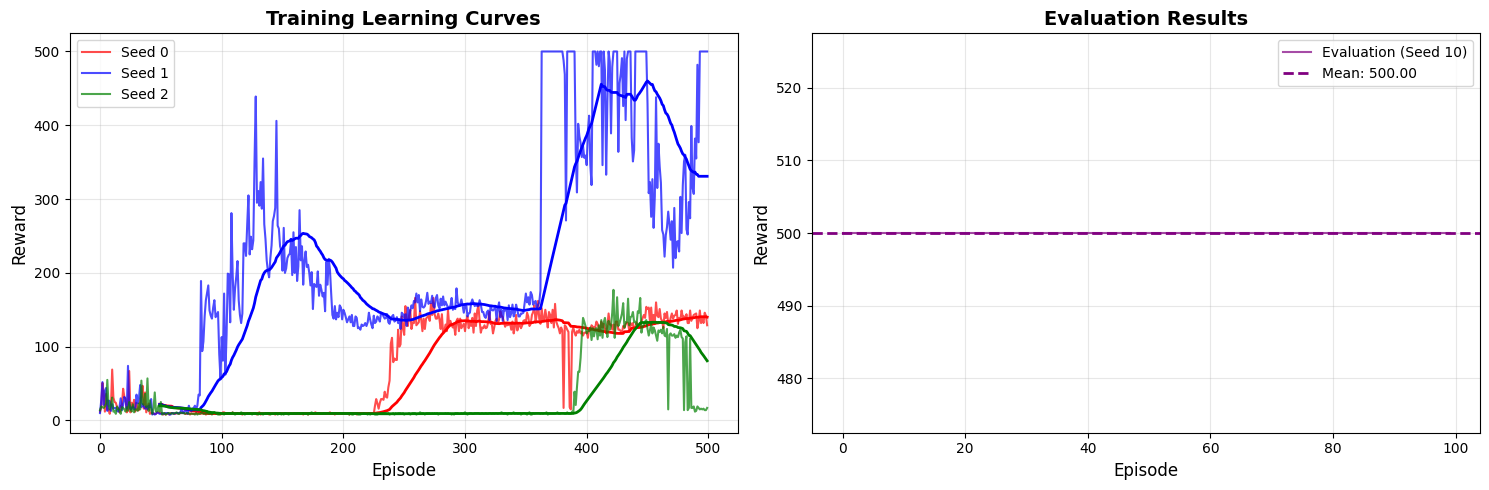

Results saved to results.json

TRAINING COMPLETE!
Final evaluation: 500.00 ± 0.00



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gymnasium as gym
from collections import deque
import random
import matplotlib.pyplot as plt
import json


class ReplayBuffer:
    """Experience replay buffer for off-policy learning"""
    def __init__(self, max_size=1000000):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)


class Actor(nn.Module):
    """Actor network for continuous action space"""
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x)) * self.max_action
        return x


class Critic(nn.Module):
    """Twin critic networks for Q-value estimation"""
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

        # Q2 architecture
        self.fc4 = nn.Linear(state_dim + action_dim, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], dim=1)

        # Q1
        q1 = F.relu(self.fc1(sa))
        q1 = F.relu(self.fc2(q1))
        q1 = self.fc3(q1)

        # Q2
        q2 = F.relu(self.fc4(sa))
        q2 = F.relu(self.fc5(q2))
        q2 = self.fc6(q2)

        return q1, q2

    def q1(self, state, action):
        sa = torch.cat([state, action], dim=1)
        q1 = F.relu(self.fc1(sa))
        q1 = F.relu(self.fc2(q1))
        q1 = self.fc3(q1)
        return q1


class TD3Agent:
    """TD3 (Twin Delayed Deep Deterministic Policy Gradient) Agent"""
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        actor_lr=3e-4,
        critic_lr=3e-4,
        gamma=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_delay=2
    ):
        self.device = device
        self.max_action = max_action
        self.gamma = gamma
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_delay = policy_delay

        # Actor networks
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

        # Critic networks
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.total_it = 0

    def select_action(self, state, noise=0.0):
        """Select action with optional exploration noise"""
        state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
        action = self.actor(state).cpu().data.numpy().flatten()

        if noise > 0:
            noise_vec = np.random.normal(0, noise, size=action.shape)
            action = action + noise_vec
            action = np.clip(action, -self.max_action, self.max_action)

        return action

    def train(self, replay_buffer, batch_size=256):
        """Train the agent using a batch of experiences"""
        self.total_it += 1

        # Sample from replay buffer
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        with torch.no_grad():
            # Select action with target policy and add clipped noise
            noise = (torch.randn_like(actions) * self.policy_noise).clamp(
                -self.noise_clip, self.noise_clip
            )
            next_actions = (self.actor_target(next_states) + noise).clamp(
                -self.max_action, self.max_action
            )

            # Compute target Q-values
            target_q1, target_q2 = self.critic_target(next_states, next_actions)
            target_q = torch.min(target_q1, target_q2)
            target_q = rewards + (1 - dones) * self.gamma * target_q

        # Get current Q estimates
        current_q1, current_q2 = self.critic(states, actions)

        # Compute critic loss
        critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)

        # Optimize critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates
        if self.total_it % self.policy_delay == 0:
            # Compute actor loss
            actor_loss = -self.critic.q1(states, self.actor(states)).mean()

            # Optimize actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Soft update target networks
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def save(self, filename):
        """Save model parameters"""
        torch.save({
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict(),
            'actor_optimizer': self.actor_optimizer.state_dict(),
            'critic_optimizer': self.critic_optimizer.state_dict(),
        }, filename)

    def load(self, filename):
        """Load model parameters"""
        checkpoint = torch.load(filename)
        self.actor.load_state_dict(checkpoint['actor'])
        self.critic.load_state_dict(checkpoint['critic'])
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer'])


def train_td3(env_name='CartPole-v1', seed=0, max_episodes=500, max_steps=500,
              batch_size=256, start_timesteps=1000, exploration_noise=0.1):
    """Train TD3 agent on CartPole environment"""

    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Create environment
    env = gym.make(env_name)
    env.reset(seed=seed)

    state_dim = env.observation_space.shape[0]
    action_dim = 1  # CartPole has discrete actions but we treat it as continuous
    max_action = 1.0

    # Initialize agent and replay buffer
    agent = TD3Agent(
        state_dim=state_dim,
        action_dim=action_dim,
        max_action=max_action,
        actor_lr=3e-4,
        critic_lr=3e-4,
        gamma=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_delay=2
    )

    replay_buffer = ReplayBuffer(max_size=1000000)

    episode_rewards = []
    total_timesteps = 0

    print(f"\n{'='*60}")
    print(f"Training TD3 on {env_name} with seed {seed}")
    print(f"{'='*60}\n")

    for episode in range(max_episodes):
        state, _ = env.reset()
        episode_reward = 0

        for step in range(max_steps):
            # Select action
            if total_timesteps < start_timesteps:
                action = np.random.uniform(-max_action, max_action, size=(action_dim,))
            else:
                action = agent.select_action(state, noise=exploration_noise)

            # Convert continuous action to discrete for CartPole
            discrete_action = 1 if action[0] > 0 else 0

            # Execute action
            next_state, reward, terminated, truncated, _ = env.step(discrete_action)
            done = terminated or truncated

            # Store transition
            replay_buffer.add(state, action, reward, next_state, float(done))

            state = next_state
            episode_reward += reward
            total_timesteps += 1

            # Train agent
            if len(replay_buffer) > batch_size:
                agent.train(replay_buffer, batch_size)

            if done:
                break

        episode_rewards.append(episode_reward)

        if episode % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:]) if len(episode_rewards) >= 50 else np.mean(episode_rewards)
            print(f"Seed {seed} | Episode {episode:4d} | Avg Reward: {avg_reward:7.2f} | Total Steps: {total_timesteps}")

    env.close()
    return agent, episode_rewards


def evaluate_agent(agent, env_name='CartPole-v1', seed=10, num_episodes=100):
    """Evaluate trained agent"""
    env = gym.make(env_name)
    env.reset(seed=seed)

    episode_rewards = []

    print(f"\n{'='*60}")
    print(f"Evaluating agent on {env_name} with seed {seed}")
    print(f"{'='*60}\n")

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.select_action(state, noise=0.0)  # No exploration
            discrete_action = 1 if action[0] > 0 else 0
            next_state, reward, terminated, truncated, _ = env.step(discrete_action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state

        episode_rewards.append(episode_reward)

        if (episode + 1) % 20 == 0:
            print(f"Episode {episode+1:3d}/{num_episodes} completed")

    env.close()

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    print(f"\n{'='*60}")
    print(f"Evaluation Results: {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"{'='*60}\n")

    return episode_rewards, mean_reward, std_reward


def plot_results(training_results, eval_results, save_path='results.png'):
    """Plot training curves and evaluation results"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training curves
    colors = ['red', 'blue', 'green']
    for seed, rewards in training_results.items():
        axes[0].plot(rewards, label=f'Seed {seed}', color=colors[seed], alpha=0.7)
        # Add moving average
        window = 50
        if len(rewards) >= window:
            moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
            axes[0].plot(range(window-1, len(rewards)), moving_avg,
                        color=colors[seed], linewidth=2)

    axes[0].set_xlabel('Episode', fontsize=12)
    axes[0].set_ylabel('Reward', fontsize=12)
    axes[0].set_title('Training Learning Curves', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot evaluation results
    axes[1].plot(eval_results, color='purple', alpha=0.7, label='Evaluation (Seed 10)')
    mean_eval = np.mean(eval_results)
    axes[1].axhline(y=mean_eval, color='purple', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_eval:.2f}')

    axes[1].set_xlabel('Episode', fontsize=12)
    axes[1].set_ylabel('Reward', fontsize=12)
    axes[1].set_title('Evaluation Results', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Results plot saved to {save_path}")
    plt.show()


def main():
    """Main training and evaluation pipeline"""

    # Hyperparameters
    HYPERPARAMETERS = {
        'actor_lr': 3e-4,
        'critic_lr': 3e-4,
        'gamma': 0.99,
        'tau': 0.005,
        'policy_noise': 0.2,
        'noise_clip': 0.5,
        'policy_delay': 2,
        'batch_size': 256,
        'buffer_size': 1000000,
        'max_episodes': 500,
        'max_steps': 500,
        'start_timesteps': 1000,
        'exploration_noise': 0.1
    }

    print("\n" + "="*60)
    print("CART-POLE TD3 TRAINING")
    print("="*60)
    print("\nHyperparameters:")
    for key, value in HYPERPARAMETERS.items():
        print(f"  {key:20s}: {value}")
    print("="*60 + "\n")

    # Train with seeds 0, 1, 2
    training_results = {}
    agents = {}

    for seed in [0, 1, 2]:
        agent, rewards = train_td3(
            env_name='CartPole-v1',
            seed=seed,
            max_episodes=HYPERPARAMETERS['max_episodes'],
            max_steps=HYPERPARAMETERS['max_steps'],
            batch_size=HYPERPARAMETERS['batch_size'],
            start_timesteps=HYPERPARAMETERS['start_timesteps'],
            exploration_noise=HYPERPARAMETERS['exploration_noise']
        )
        training_results[seed] = rewards
        agents[seed] = agent

        # Save trained agent
        agent.save(f'td3_cartpole_seed{seed}.pth')
        print(f"Agent saved to td3_cartpole_seed{seed}.pth\n")

    # Evaluate with seed 10 using the best performing agent
    best_seed = max(training_results.keys(),
                   key=lambda s: np.mean(training_results[s][-100:]))
    print(f"Using agent from seed {best_seed} for evaluation")

    eval_rewards, mean_eval, std_eval = evaluate_agent(
        agents[best_seed],
        env_name='CartPole-v1',
        seed=10,
        num_episodes=100
    )

    # Plot results
    plot_results(training_results, eval_rewards)

    # Save results to JSON
    results = {
        'hyperparameters': HYPERPARAMETERS,
        'training': {str(k): v for k, v in training_results.items()},
        'evaluation': {
            'rewards': eval_rewards,
            'mean': float(mean_eval),
            'std': float(std_eval)
        }
    }

    with open('results.json', 'w') as f:
        json.dump(results, f, indent=2)
    print("Results saved to results.json")

    print("\n" + "="*60)
    print("TRAINING COMPLETE!")
    print("="*60)
    print(f"Final evaluation: {mean_eval:.2f} ± {std_eval:.2f}")
    print("="*60 + "\n")


if __name__ == "__main__":
    main()

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!git --version


git version 2.34.1


In [8]:
!git clone https://github.com/navyas1402@gmail.com


Cloning into 'navyas1402@gmail.com'...
remote: Not Found
fatal: repository 'https://github.com/navyas1402@gmail.com/' not found
